# Modélisation et évaluation des modèles

**Auteur :** Mehdi MUNIM

**Date :** 2023-11-26

**Description :**

Ce notebook entraîne et évalue différents modèles de Machine Learning pour la classification de sentiment sur les données de tweets prétraitées.

In [1]:
#@title 1. Importation des librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys

# Ajouter le chemin du dossier src pour importer les modules
sys.path.append('../src')
import model
import evaluation

2024-11-26 18:03:07.886580: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Chargement des données

In [2]:
#@title 2.1 Chargement des données

# Chemin d'accès au dossier data
data_path = '../data/processed/'

# Charger les données prétraitées
X_train_tfidf = pickle.load(open(data_path + 'X_train_tfidf.pickle', 'rb'))
X_test_tfidf = pickle.load(open(data_path + 'X_test_tfidf.pickle', 'rb'))
X_train_w2v = pickle.load(open(data_path + 'X_train_word2vec.pickle', 'rb'))
X_test_w2v = pickle.load(open(data_path + 'X_test_word2vec.pickle', 'rb'))
X_train_d2v = pickle.load(open(data_path + 'X_train_doc2vec.pickle', 'rb'))
X_test_d2v = pickle.load(open(data_path + 'X_test_doc2vec.pickle', 'rb'))
y_train = pickle.load(open(data_path + 'y_train.pickle', 'rb'))
y_test = pickle.load(open(data_path + 'y_test.pickle', 'rb'))

## 3. Entraînement et évaluation des modèles

Accuracy: 0.7601
Precision: 0.7407
Recall: 0.7936
F1-score: 0.7662


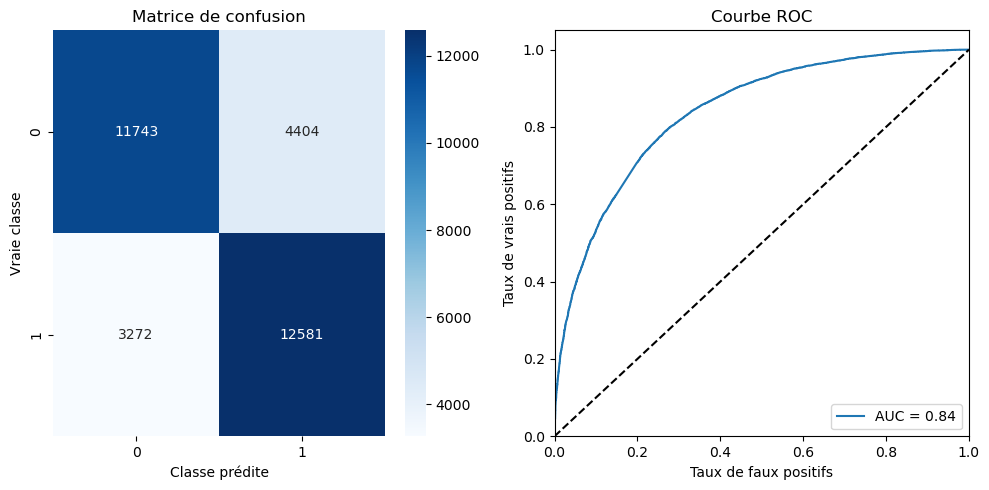

In [3]:
#@title 3.1 Entraînement et évaluation du modèle de régression logistique

from sklearn.linear_model import LogisticRegression

# Créer et entraîner le modèle de régression logistique
model_lr = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
model_lr.fit(X_train_tfidf, y_train)

# Évaluer le modèle
evaluation.evaluer_modele(model_lr, X_test_tfidf, y_test)

Epoch 1/10
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5751 - accuracy: 0.6994 - val_loss: 0.5434 - val_accuracy: 0.7243
Epoch 2/10
3200/3200 [==============================] - 8s 3ms/step - loss: 0.5569 - accuracy: 0.7174 - val_loss: 0.5496 - val_accuracy: 0.7122
Epoch 3/10
3200/3200 [==============================] - 8s 3ms/step - loss: 0.5525 - accuracy: 0.7199 - val_loss: 0.5421 - val_accuracy: 0.7220
Epoch 4/10
3200/3200 [==============================] - 7s 2ms/step - loss: 0.5509 - accuracy: 0.7217 - val_loss: 0.5387 - val_accuracy: 0.7246
Epoch 5/10
3200/3200 [==============================] - 7s 2ms/step - loss: 0.5487 - accuracy: 0.7213 - val_loss: 0.5379 - val_accuracy: 0.7257
Epoch 6/10
3200/3200 [==============================] - 7s 2ms/step - loss: 0.5466 - accuracy: 0.7229 - val_loss: 0.5338 - val_accuracy: 0.7315
Epoch 7/10
3200/3200 [==============================] - 6s 2ms/step - loss: 0.5464 - accuracy: 0.7233 - val_loss: 0.5331 - val_accuracy

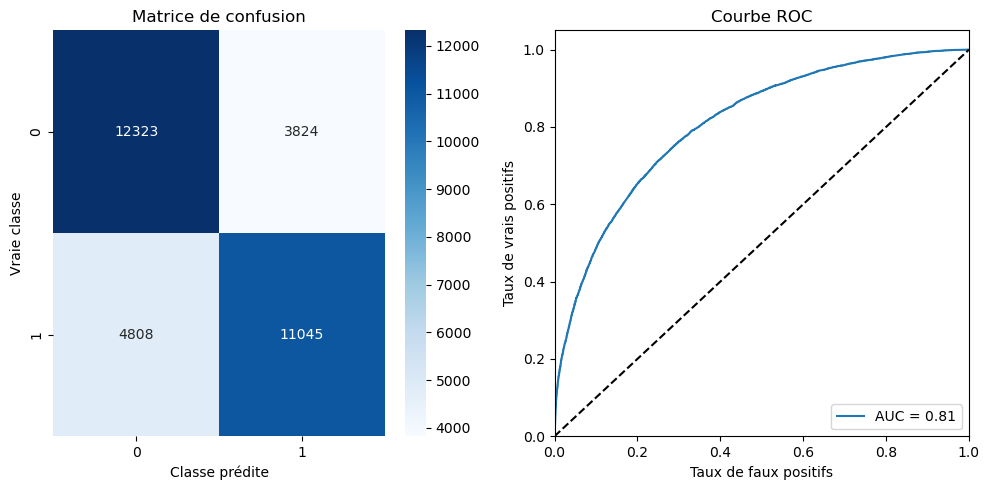

In [6]:
#@title 3.2 Entraînement et évaluation du modèle MLP

# Créer et entraîner le modèle MLP
model_mlp = model.create_mlp_model(input_shape=(X_train_w2v.shape[1],))
model_mlp.fit(X_train_w2v, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Évaluer le modèle
evaluation.evaluer_modele(model_mlp, X_test_w2v, y_test)

Epoch 1/10
3200/3200 [==============================] - 24s 7ms/step - loss: 0.5588 - accuracy: 0.7092 - val_loss: 0.5430 - val_accuracy: 0.7217
Epoch 2/10
3200/3200 [==============================] - 23s 7ms/step - loss: 0.5435 - accuracy: 0.7229 - val_loss: 0.5407 - val_accuracy: 0.7228
Epoch 3/10
3200/3200 [==============================] - 24s 7ms/step - loss: 0.5391 - accuracy: 0.7241 - val_loss: 0.5345 - val_accuracy: 0.7279
Epoch 4/10
3200/3200 [==============================] - 25s 8ms/step - loss: 0.5367 - accuracy: 0.7279 - val_loss: 0.5342 - val_accuracy: 0.7266
Epoch 5/10
3200/3200 [==============================] - 22s 7ms/step - loss: 0.5348 - accuracy: 0.7276 - val_loss: 0.5337 - val_accuracy: 0.7309
Epoch 6/10
3200/3200 [==============================] - 22s 7ms/step - loss: 0.5323 - accuracy: 0.7298 - val_loss: 0.5310 - val_accuracy: 0.7298
Epoch 7/10
3200/3200 [==============================] - 26s 8ms/step - loss: 0.5312 - accuracy: 0.7306 - val_loss: 0.5324 - val_ac

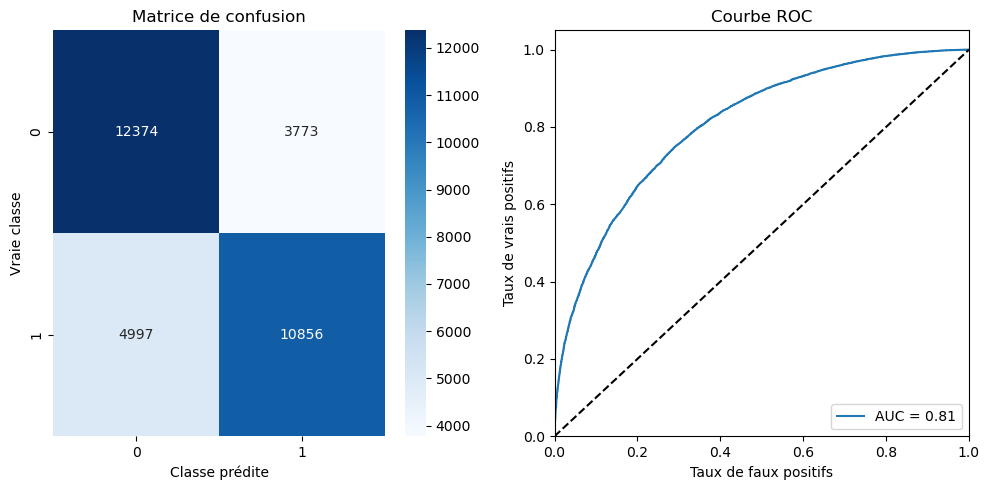

In [7]:
#@title 3.3 Entraînement et évaluation du modèle CNN

# Reshape les données pour le modèle CNN
X_train_cnn = np.reshape(X_train_w2v, (X_train_w2v.shape[0], X_train_w2v.shape[1], 1))
X_test_cnn = np.reshape(X_test_w2v, (X_test_w2v.shape[0], X_test_w2v.shape[1], 1))

# Créer et entraîner le modèle CNN
model_cnn = model.create_cnn_model(input_shape=(X_train_cnn.shape[1], 1))
model_cnn.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Évaluer le modèle
evaluation.evaluer_modele(model_cnn, X_test_cnn, y_test)

In [ ]:
#@title 3.4 Entraînement et évaluation du modèle LSTM

# Créer et entraîner le modèle LSTM
model_lstm = create_lstm_model(input_shape=(X_train_w2v.shape[1],))
model_lstm.fit(X_train_w2v, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Évaluer le modèle
evaluation.evaluer_modele(model_lstm, X_test_w2v, y_test)

Epoch 1/10
3200/3200 [==============================] - 15s 4ms/step - loss: 0.5587 - accuracy: 0.7110 - val_loss: 0.5407 - val_accuracy: 0.7254
Epoch 2/10
3200/3200 [==============================] - 12s 4ms/step - loss: 0.5426 - accuracy: 0.7225 - val_loss: 0.5339 - val_accuracy: 0.7292
Epoch 3/10
3200/3200 [==============================] - 11s 4ms/step - loss: 0.5380 - accuracy: 0.7258 - val_loss: 0.5328 - val_accuracy: 0.7281
Epoch 4/10
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5346 - accuracy: 0.7273 - val_loss: 0.5289 - val_accuracy: 0.7322
Epoch 5/10
3184/3200 [============================>.] - ETA: 0s - loss: 0.5322 - accuracy: 0.7301

In [ ]:
#@title 3.5 Entraînement et évaluation du modèle BERT

# Créer et entraîner le modèle BERT
model_bert, tokenizer = model.create_bert_model()

# Tokenizer les tweets d'entraînement et de test
X_train_bert = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors="tf")
X_test_bert = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors="tf")

# Convertir les labels en tenseurs
y_train_bert = tf.convert_to_tensor(y_train)
y_test_bert = tf.convert_to_tensor(y_test)

# Entraîner le modèle
history = model_bert.fit(
    x={"input_ids": X_train_bert["input_ids"], "attention_mask": X_train_bert["attention_mask"]},
    y=y_train_bert,
    validation_split=0.2,
    epochs=3,
    batch_size=8,
)

# Évaluer le modèle
y_pred_bert = model_bert.predict(X_test_bert).logits
y_pred_bert = np.argmax(y_pred_bert, axis=1)
evaluation.evaluer_modele(model_bert,
                          {"input_ids": X_test_bert["input_ids"], "attention_mask": X_test_bert["attention_mask"]},
                          y_test_bert)

In [ ]:
#@title 3.6 Entraînement et évaluation du modèle USE

import tensorflow_hub as hub

# Charger le modèle USE
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Encoder les tweets
X_train_use = embed(X_train)
X_test_use = embed(X_test)

# Créer et entraîner le modèle USE
model_use = model.create_use_model(input_shape=(X_train_use.shape[1],))
model_use.fit(X_train_use, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Évaluer le modèle
evaluation.evaluer_modele(model_use, X_test_use, y_test)

## 4. Comparaison des modèles

In [ ]:
#@title Comparaison des modèles
# Fonction pour comparer les modèles en utilisant les métriques d'évaluation
def comparer_modeles(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

# Comparaison des modèles
modeles = [model_baseline, model_mlp, model_cnn, model_lstm]
noms_modeles = ['Régression Logistique', 'MLP', 'CNN', 'LSTM']
y_preds = [model.predict(X_test_kbest) for model in modeles]

# Calculer les métriques pour chaque modèle
resultats = []
for y_pred in y_preds:
    resultats.append(comparer_modeles(y_test, y_pred))

# Créer un DataFrame pour afficher les résultats
comparaison = pd.DataFrame(resultats, columns=['Accuracy', 'Precision', 'Recall', 'F1-score'], index=noms_modeles)

# Afficher les résultats
print(comparaison)